# Process MRZERO simulated MEGE data
(C) 2025 Forschungszentrum Jülich

Author: Jörg Felder

In [1]:
import os
import sys

sys.path.insert(0, "../src")

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import ismrmrd
import torch
import h5py

import matplotlib.pyplot as plt
import numpy as np

from juart.preproc.data import KSpaceData
from juart.conopt.functional.fourier import fourier_transform_adjoint
from juart.preproc.trajectory import KSpaceTrajectory

torch.set_num_threads(1)

In [2]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'

In [3]:
# load ISMRMRD File
full_h5_ismrmrd_fname = os.path.join(filepath, 'LocalData', 'Simulations', 'mege.h5')
dataset = ismrmrd.Dataset(
    full_h5_ismrmrd_fname,
    dataset_name="dataset",
    create_if_needed=False,
)

In [4]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'mege_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]

In [21]:
NCha = 1
NCol = matrix_size[1]
NLin = num_spokes
NPar = matrix_size[2]
NSli = 8
NSet = 1
NEco = num_echoes

NPar_post, NSli_post = NSli, NPar
NCha_comp, ISet_comp, IEco_comp = NCha, slice(NSet - 1, NSet), slice(0, 1)
NImx, NImy, ISet_coil, IEco_coil = 256, 256, slice(4, 5), slice(0, 1)

NAcl = num_autocalibration_lines
NUsf = acceleration_factor
NLin_retro = NLin

In [22]:
print(NCha, NCol, NLin, NPar, NSli, NSet, NEco)

1 256 32 12 8 1 9


In [23]:
# load kspace
kdata = KSpaceData((NCha, NCol, NLin, NPar, NSli, NSet, NEco))
kdata.read_data(dataset, is_pulseq=True)

  0%|          | 0/3456 [00:00<?, ?it/s]

IndexError: index 65531 is out of bounds for dimension 3 with size 12

In [24]:
# Undersample along line dimension
# Here we keep the data size unchaged as we did not oversample in the simulation
kdata.index_data([slice(None), slice(None), slice(NLin_retro), ...])

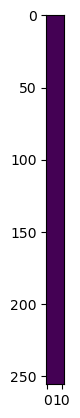

In [25]:
plt.figure()
plt.imshow(torch.log(torch.abs(kdata.kdata[0, :, 0, :, 0, 0, 0]) + 1e-16).numpy())

### Grappa

In [26]:
kdata.apply_mask(NUsf, NAcl, is_pulseq=True)
kdata.reconstruct_partitions()

  0%|          | 0/288 [00:00<?, ?it/s]

### Coil compression

In [27]:
# Swap Par and Sli Partition
kdata.swapaxes(3, 4)

In [28]:
# comp_matrix = kdata.compression_matrix(NCha_comp, ISet_comp, IEco_comp)
# kdata.compress_data(comp_matrix)

In [29]:
# Swap Col and Lin dimension
kdata.swapaxes(1, 2)

In [30]:
NCha, NLin, NCol, NPar, NSli, NSet, NEco = kdata.kdata_shape

In [31]:
print(NCha, NCol, NLin, NPar, NSli, NSet, NEco)

1 256 32 8 12 1 9


In [32]:
print("(4/4) Creating output file ....")
full_h5_preproc_fname = os.path.join(filepath, 'LocalData', 'Simulations','mege_grappa_pytorch.h5')

with h5py.File(full_h5_preproc_fname, "w", libver="latest") as out_file:
    out_file.create_dataset(
        "d", data=kdata.kdata.numpy(), chunks=(NCha, NLin, NCol, 1, 1, 1, 1)
    )

(4/4) Creating output file ....


In [33]:
print(kdata.kdata[0, 0, :, 0, :, 0, 0].T.numpy().shape)

(12, 256)


(np.float64(-0.5), np.float64(255.5), np.float64(11.5), np.float64(-0.5))

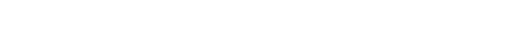

In [34]:
plt.imshow(
    torch.log(torch.abs(kdata.kdata[0, 0, :, 0, :, 0, 0].T)).numpy())
plt.axis("off")

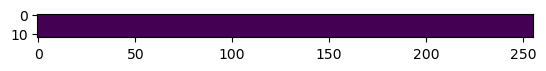

In [35]:
plt.figure()
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[0, 0, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=200,
)

In [36]:
print(kdata.kdata.shape)

torch.Size([1, 32, 256, 8, 12, 1, 9])


### Gradient delay correction - here obsolete

In [37]:
ktraj = KSpaceTrajectory(NLin, NCol, NSet, NEco)

In [38]:
with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
    dset = h5_preproc_file.create_dataset(
        "k", data=ktraj.ktraj_nom.numpy(), chunks=(2, NLin_retro, NCol, 1, 1, 1, 1)
    )

### Coil Sensitivity Estimation (SAKE + ESPIRiT)

In [39]:
# sensmaps = kdata.get_sensmaps(ktraj.ktraj_nom, (NCha, NImx, NImy, 1, NSli, 1, 1), multi_contrast=False)
sensmaps = torch.ones((NCha, NImx, NImy, 1, NSli, 1, 1), dtype=torch.complex64)

In [40]:
print(sensmaps.shape)

torch.Size([1, 256, 256, 1, 12, 1, 1])


In [41]:
with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
    dset = h5_preproc_file.create_dataset(
        "C",
        data=sensmaps.numpy(),
        chunks=(NCha_comp, NImx, NImy, NPar_post, NSli_post, 1, 1),
    )

ValueError: Chunk shape must not be greater than data shape in any dimension. (1, 256, 256, 8, np.int64(12), 1, 1) is not compatible with (1, 256, 256, 1, 12, 1, 1)

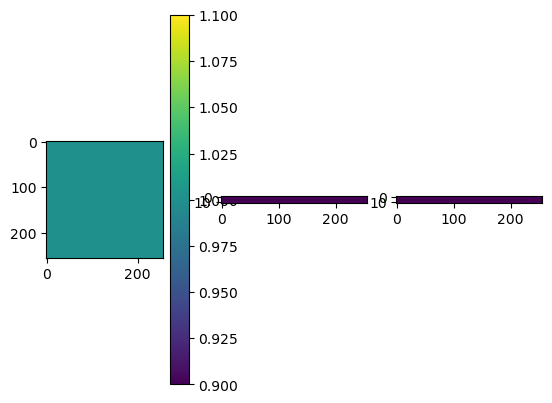

In [42]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(torch.abs(sensmaps[0, :, :, 0, matrix_size[2]//2, 0, 0]).numpy())
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(torch.abs(sensmaps[0, :, matrix_size[1]//2, 0, :, 0, 0]).T.numpy())
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(sensmaps[0, matrix_size[0]//2, :, 0, :, 0, 0]).T.numpy())

In [43]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(torch.abs(sensmaps[0, :, matrix_size[1]//2, 0, :, 0, 0].T).numpy(), vmin=0, vmax=1)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(torch.abs(sensmaps[-1, :, matrix_size[1]//2, 0, :, 0, 0].T).numpy(), vmin=0, vmax=1)
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(11.5), np.float64(-0.5))